In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
# Load and preprocess MNIST data
# Convert an image into tensor with the pixel value range of 0 and 1
transform = transforms.ToTensor()

# Data download, train, and transformation
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders - load and process data in batches of 64 for training and 1000 for testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.83MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.62MB/s]


In [3]:
# Check the shape
for data, target in train_loader:
    print(data.shape)
    break

torch.Size([64, 1, 28, 28])


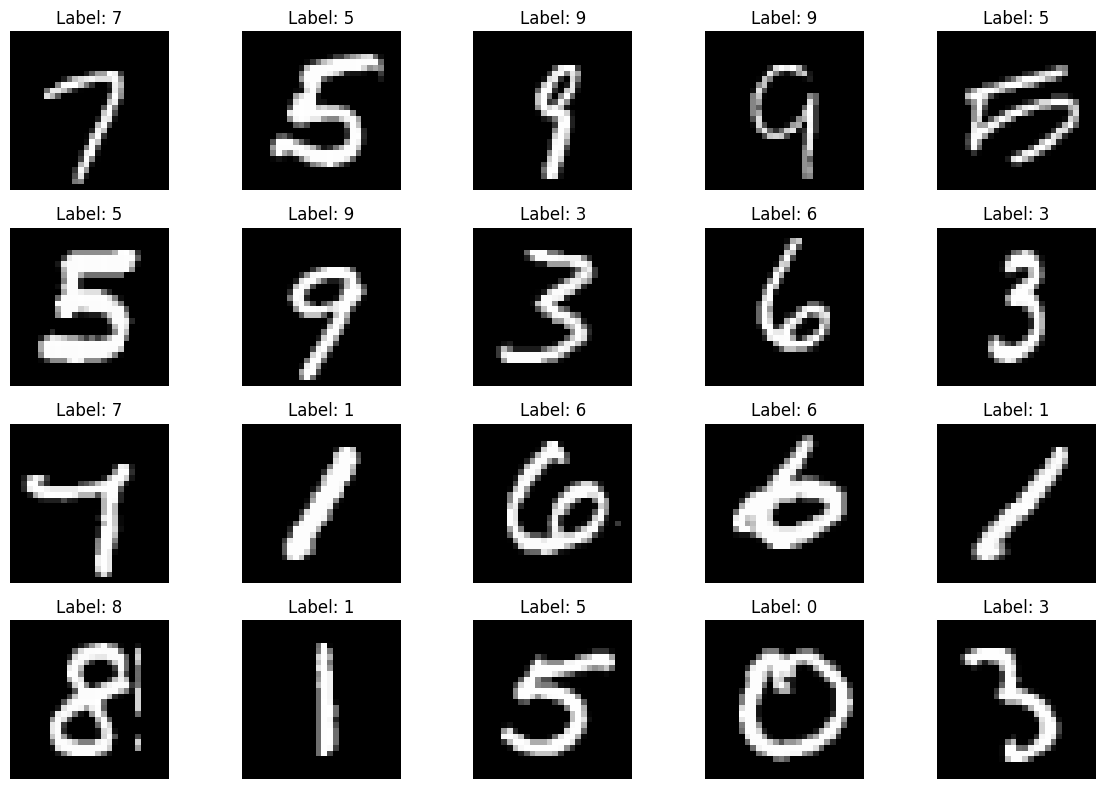

In [4]:
# The first 10 images
data, target = next(iter(train_loader))
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
for i in range(20):
    axes[i // 5, i % 5].imshow(data[i].squeeze(), cmap='gray')
    axes[i // 5, i % 5].set_title(f"Label: {target[i].item()}")
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show();

In [5]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # This model uses GPU
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [7]:
# Train the model
model.train()
for epoch in range(5):
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [8]:
# Evaluate accuracy
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

accuracy = 100. * correct / len(test_loader.dataset)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 99.04%


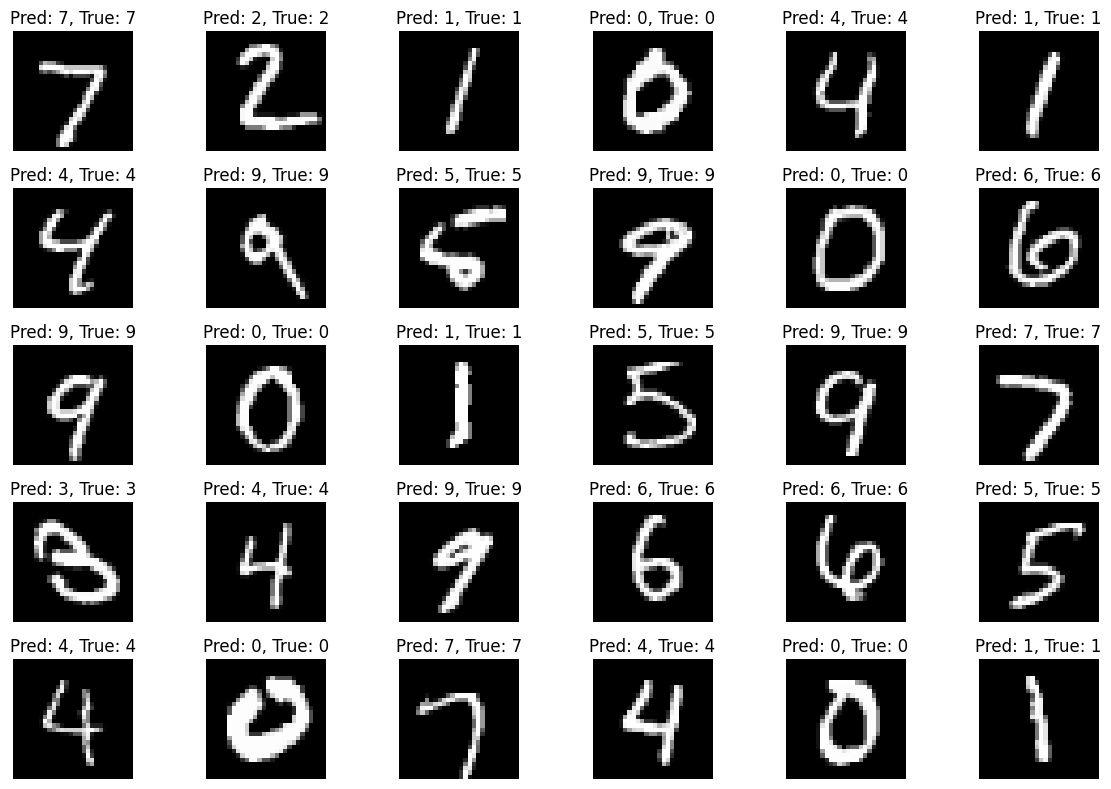

In [9]:
#  Visualize predictions
model.eval()
with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)

    fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 8))
    for i in range(5):
        for j in range(6):
            idx = i * 6 + j
            axes[i, j].imshow(data[idx].cpu().squeeze(), cmap='gray')
            axes[i, j].set_title(f"Pred: {output[idx].argmax().item()}, True: {target[idx].item()}")
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show();

In [10]:
# Save the model
torch.save(model.state_dict(), 'mnist_cnn_model.pth')

In [11]:
model.load_state_dict(torch.load('mnist_cnn_model.pth'))

<All keys matched successfully>

In [12]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Define the CNN model (must be the same as the training script)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
model = CNN()
model.load_state_dict(torch.load('mnist_cnn_model.pth', map_location=torch.device('cpu')))
model.eval()

# Define transformations for the input image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Streamlit app interface
st.title("MNIST Digit Recognizer")
st.write("Upload an image of a handwritten digit to get a prediction.")

uploaded_file = st.file_uploader("Choose an image...", type=["png", "jpg", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image.", use_column_width=True)

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)

    # Make a prediction
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1).item()

    st.write(f"Prediction: {prediction}")

Writing app.py


In [13]:
!streamlit run app.py &>/dev/null&

# **Reference**
The link to the project is [MNIST Classifier](https://drive.google.com/file/d/1vKrWAeai70kKpSOxdgs2W8HqQaS_GbtO/view?usp=sharing)

In [16]:
# from google.colab import output
# output.serve_site(port=8501, height=1000)